In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import sklearn.datasets


In [2]:
class Block(nn.Module):
    """A basic block used to build ResNet."""

    def __init__(self, num_channels):
        """Initialize a building block for ResNet.

        Argument:
            num_channels: the number of channels of the input to Block, and is also
                          the number of channels of conv layers of Block. It is the
                          parameter C in the handout hw3.pdf.
        """
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size = 3, stride=1, padding = 1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size = 3, stride=1, padding = 1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        """
        The input will have shape (N, num_channels, H, W),
        where N is the batch size, and H and W give the shape of each channel.
        The output should have the same shape as input.
        """
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
#         print('From block ', x.shape)
        x += identity
        x = self.relu2(x)
        
        return x

In [3]:
class ResNet(nn.Module):
    
    def __init__(self, num_channels, num_classes=10):
        """x
        Arguments:
            num_channels: the number of output channels of the conv layer
                          before the building block, and also 
                          the number of channels of the building block.
            num_classes: the number of output units.
        """
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, num_channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
#         blocklayer = Block(num_channels)
#         self.block = blocklayer()
        self.block = Block(num_channels)
    
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(num_channels, num_classes)
        
    def forward(self, x):
        """
        The input will have shape (N, 1, H, W),
        where N is the batch size, and H and W give the shape of each channel.

        The output should have shape (N, 10).
        """
#         print('X shape ', x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
#         print('X shape ', x.shape)
#         blocklayer = Block(num_channels)
#         x = blocklayer(x)
        x = self.block(x)
#         print('X shape2 ', x.shape)
        
        x = self.avgpool(x)
#         print('X shape avg pool ', x.shape)

        x = x.view(x.shape[0],-1)
#         print('X shape3', x.shape)
        x = self.linear(x)
#         x.view(-1, 10)
#         print('After linear ', x.shape)
        return x

In [4]:
def plot_resnet_loss_1():
    """
    Train ResNet with different parameters C on digits data and draw the training
    error vs the test error curve. To make life easier, we provide you with the
    starter code to load the digits data and draw the figures with different
    parameters C. You do not need to modify the starter code and you only need
    to implement the training part. Train your algorithms for 4000 epochs with mini
    batch size = 128 and step size 0.1.
    """
    
    sk_digits = sklearn.datasets.load_digits()
    (X, Y) = (torch.tensor(sk_digits.data).type(torch.float), torch.tensor(sk_digits.target))
    Y = Y.type(torch.LongTensor)
    print(X.shape, Y.shape, X.max(), X.min())
    X /= X.max()
    n = X.shape[0]
    perm = list(range(n))
    random.shuffle(perm)
    (X, Y) = ({'tr': X[perm[:n//2], ...], 'te': X[perm[n//2:], ...]}, {'tr':Y[perm[:n//2]], 'te':Y[perm[n//2:]]})
    mb_sz = 128
    stepsize = 0.1

    for (_, (net_s, num_channels)) in enumerate([
        ('ResNet_1', 1),
        ('ResNet_2', 2),
        ('ResNet_4', 4),
    ]):
        losses = { 'tr' : [], 'te' : [] }
        net =  ResNet(num_channels)
        for i in range(4000):
            idxs = random.sample(range(X['tr'].shape[0]), mb_sz)
            (x, y) = (X['tr'][idxs, ...], Y['tr'][idxs])
            x = x.view(x.shape[0], 1, 8, 8)
                
            yhat = net.forward(x)
            
            loss1 = torch.nn.CrossEntropyLoss()
            
            optimizer = torch.optim.SGD(net.parameters(), lr=stepsize)
            
            loss = loss1(yhat, y)
            
            with torch.no_grad():
                if (i + 1) % 25 == 0:
                    x = X['te']
                    x = x.view(x.shape[0], 1, 8, 8)
                    yhat2 = net(x)
                    loss2 = torch.nn.CrossEntropyLoss()(yhat2, Y['te'])
#                     print(f"{i} {loss:.3f} {loss2:.3f}")
                    losses['tr'].append(loss.detach())
                    losses['te'].append(loss2.detach())
                    
                loss.backward()
            
                optimizer.step()
    
                optimizer.zero_grad()
        
        for s in ['tr', 'te']:
            plt.figure(1)
            plt.plot(range(len(losses[s])), losses[s],
                     label = f"{net_s} {s}")
                     
    plt.figure(1)
    plt.title("risk curves")
    plt.legend()
    plt.savefig('f1.pdf')
    plt.show()        

In [5]:
# m = nn.AdaptiveAvgPool2d((5,7))
# input = torch.randn(1, 8, 9)
# output = m(input)
# print('Input ', input, '\nOutput', output)

torch.Size([1797, 64]) torch.Size([1797]) tensor(16.) tensor(0.)


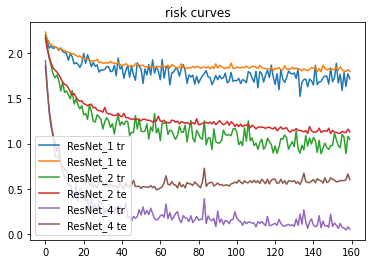

In [6]:
plot_resnet_loss_1()

In [7]:
def plot_resnet_loss_2():
    """
    Train ResNet with parameter C = 64 on digits data and draw the training
    error vs the test error curve. To make your life easier, we provide you with the
    starter code to load the digits data and draw the figures with C = 64.
    You do not need to modify the starter code (but you can if you want) and you only
    need to implement the training part. Train your algorithms for 4000 epochs
    using SGD with mini batch size = 128 and step size 0.1. Notice that in the
    starter code, we have selected the mini batch data for you.
    
    Updated in version 1.1: speficy to use SGD.
    """
    
    sk_digits = sklearn.datasets.load_digits()
    (X, Y) = (torch.tensor(sk_digits.data).type(torch.float), torch.tensor(sk_digits.target))
    Y = Y.type(torch.LongTensor)
    print(X.shape, Y.shape, X.max(), X.min())
    X /= X.max()
    n = X.shape[0]
    perm = list(range(n))
    random.shuffle(perm)
    (X, Y) = ({'tr': X[perm[:n//2], ...], 'te': X[perm[n//2:], ...]}, {'tr':Y[perm[:n//2]], 'te':Y[perm[n//2:]]})
    mb_sz = 128
    stepsize = 0.1

    for (_, (net_s, num_channels)) in enumerate([
        ('ResNet_64', 64),
    ]):
        losses = { 'tr' : [], 'te' : [] }
        net =  ResNet(num_channels)
        for i in range(4000):
            idxs = random.sample(range(X['tr'].shape[0]), mb_sz)
            (x, y) = (X['tr'][idxs, ...], Y['tr'][idxs])
            x = x.view(x.shape[0], 1, 8, 8)
        
            yhat = net.forward(x)
            
            loss1 = torch.nn.CrossEntropyLoss()
            
            optimizer = torch.optim.SGD(net.parameters(), lr=stepsize)
            
            loss = loss1(yhat, y)
            
            with torch.no_grad():
                if (i + 1) % 25 == 0:
                    x = X['te']
                    x = x.view(x.shape[0], 1, 8, 8)
                    yhat2 = net(x)
                    loss2 = torch.nn.CrossEntropyLoss()(yhat2, Y['te'])
#                     print(f"{i} {loss:.3f} {loss2:.3f}")
                    losses['tr'].append(loss.detach())
                    losses['te'].append(loss2.detach())
                    
                loss.backward()
            
                optimizer.step()
    
                optimizer.zero_grad()
        
        for s in ['tr', 'te']:
            plt.figure(1)
            plt.plot(range(len(losses[s])), losses[s],
                     label = f"{net_s} {s}")
                     
    plt.figure(1)
    plt.title("risk curves")
    plt.legend()
    plt.savefig('f2.pdf')
    plt.show()


torch.Size([1797, 64]) torch.Size([1797]) tensor(16.) tensor(0.)


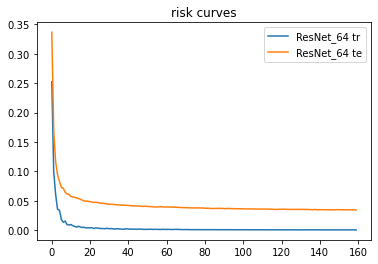

In [8]:
plot_resnet_loss_2()